### Recommendation Framework for Hotels Dataset

[Kaggle Dataset](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe)

#### Import libraries

| Data processing/ file management       | Wordcloud           | Recommendation  | Plotting |
| :------------------------------------- |:--------------------| :---------------| :--------|
| pandas | wordcloud | scipy  | matplotlib |
| numpy  | -         | sklearn| seaborn    |
| pathlib| -         | -      | -          |


In [2]:
import pandas as pd
import numpy as np
from pathlib import os
from tqdm.notebook import tqdm

In [3]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
import scipy.spatial.distance
from sklearn import preprocessing
from scipy.spatial.distance import cdist

from sklearn.manifold import TSNE

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

    sns.color_palette(sns.set_palette("RdBu",4))
    
set_style()

#### Load dataset to pandas dataframe + Preprocessing

In [109]:
# Load data
df = pd.read_csv(r'Hotel_Reviews.csv')

# Convert columns to lowercase
df.columns = df.columns.str.lower()

# Modify tags column into separate columns with each tag. Remove unwanted string items
df['tags'] = df['tags'].str.replace('[','').str.replace(']','').\
                        str.replace("'","").str.replace(" trip ","").\
                        str.replace("  "," ").str.replace(" ,",",").\
                        str.replace("Stayed ", "")
df['tags'] = df['tags'].apply(lambda x: x.split(',')[0:4])
df[['trip_type','customer_type', 'room_type', 'stay']] = pd.DataFrame(df.tags.tolist(), index= df.index)
df.drop('tags', axis=1, inplace=True)

df.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,trip_type,customer_type,room_type,stay
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,0 days,52.360576,4.915968,Leisure,Couple,Duplex Double Room,6 nights
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,0 days,52.360576,4.915968,Leisure,Couple,Duplex Double Room,4 nights
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,3 days,52.360576,4.915968,Leisure,Family with young children,Duplex Double Room,3 nights
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,3 days,52.360576,4.915968,Leisure,Solo traveler,Duplex Double Room,3 nights
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,10 days,52.360576,4.915968,Leisure,Couple,Suite,2 nights


#### Data Analysis: Keywords in negative and positive reviews

##### Select the hotel with maximum number of reviews

In [110]:
hotel = df.groupby('hotel_name').mean()['total_number_of_reviews'].idxmax(axis=1)
# hotel = df['hotel_name'][1]

In [111]:
negs = df['negative_review'][df['hotel_name']==hotel]
pos = df['positive_review'][df['hotel_name']==hotel]

##### Define some stopwords in addition to the stopwords from wordcloud library

In [112]:
stopwords = set(STOPWORDS)
_ = [stopwords.add(word) for word in ['hotel', 'room', 'looked', 'something', 'made', 'via', 
                                  'came', 'hello', 'offered', 'make', 'pretty', 'next', 'negative', 'positive',
                                  'wasn', 'didn', 'got', 'said', 'stay'
                                 ]]

##### Generate wordcloud

In [113]:
wc = WordCloud(background_color="black", max_words=2000, width=300, height=400, #mask=alice_coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)
neg_wordcloud = wc.generate(' '.join(negs.values))

wc = WordCloud(background_color="white", max_words=2000, width=300, height=400,#mask=alice_coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)
pos_wordcloud = wc.generate(' '.join(pos.values))

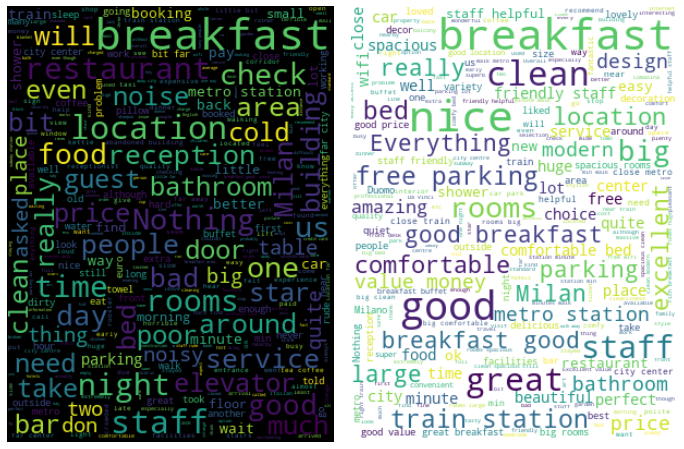

In [114]:
f = plt.figure(figsize=(12,16))
plt.subplot(121)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.subplot(122)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

#### Data Analysis: City based hotel comparisons

In [165]:
df['city'] = df['hotel_address'].apply(lambda x: [word for word in x.lower().split(' ') if word in ['london', 
                                                                                         'paris', 
                                                                                         'barcelona', 
                                                                                         'vienna', 
                                                                                         'amsterdam', 
                                                                                         'milan']][0]) 

In [167]:
df.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,trip_type,customer_type,room_type,stay,city
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,...,7,2.9,0 days,52.360576,4.915968,Leisure,Couple,Duplex Double Room,6 nights,amsterdam
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,...,7,7.5,0 days,52.360576,4.915968,Leisure,Couple,Duplex Double Room,4 nights,amsterdam
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,...,9,7.1,3 days,52.360576,4.915968,Leisure,Family with young children,Duplex Double Room,3 nights,amsterdam
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,...,1,3.8,3 days,52.360576,4.915968,Leisure,Solo traveler,Duplex Double Room,3 nights,amsterdam
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,...,3,6.7,10 days,52.360576,4.915968,Leisure,Couple,Suite,2 nights,amsterdam


In [168]:
import spacy
nlp = spacy.load('en_core_web_sm')

gpe = [] # countries, cities, states
loc = [] # non gpe locations, mountain ranges, bodies of water


doc = nlp('\n'.join(df['hotel_address'].unique()))
for ent in doc.ents:
    if (ent.label_ == 'GPE'):
        gpe.append(ent.text)
    elif (ent.label_ == 'LOC'):
        loc.append(ent.text)

In [172]:
hotels = df.groupby(['hotel_name', 'city']).mean()

In [250]:
loc = {'london':[51.5074, -0.1278],
       'paris': [48.8566, 2.3522],
       'amsterdam': [52.3667, 4.8945],
       'milan': [45.4642, 9.1900],
       'vienna': [48.2082, 16.3738],
       'barcelona': [41.3851, 2.1734]
      }

In [328]:
hotels.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat',
       'lng'],
      dtype='object')

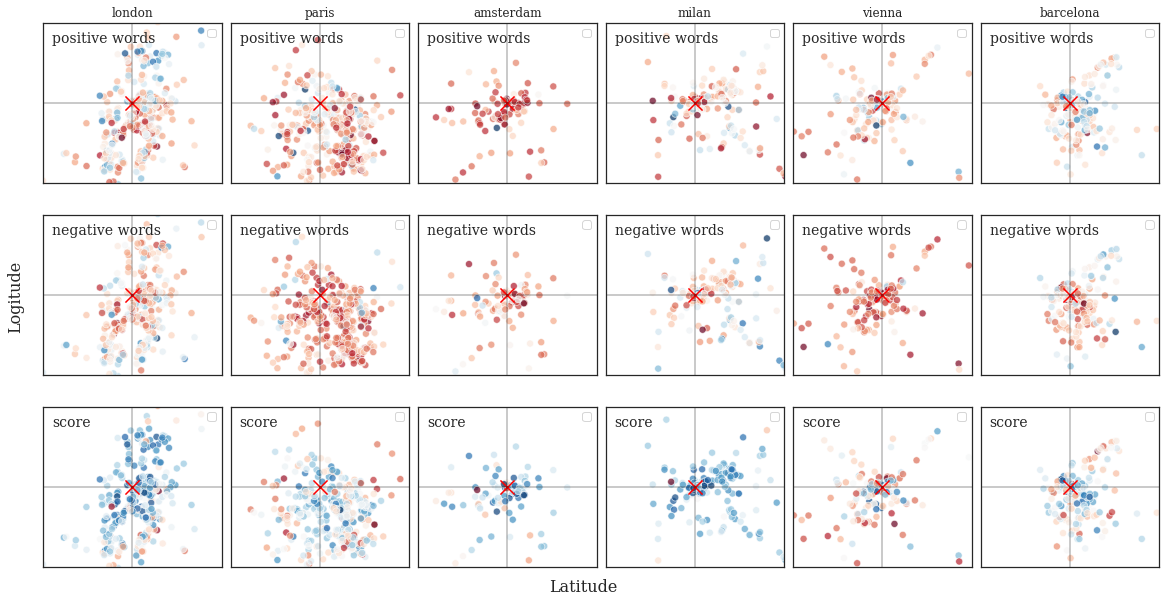

In [560]:
f, axes = plt.subplots(ncols=6, nrows=3, sharex=False, sharey=False, figsize=(20,10))

cols = ['review_total_positive_word_counts', 'review_total_negative_word_counts', 'average_score']
text = ['positive words', 'negative words', 'score']

for i,ax in enumerate(axes.flatten()):
    city = list(loc.keys())[int(i%6)]
    hdf = hotels[hotels.index.get_level_values('city') == city]
    cb = sns.scatterplot(hdf['lat'], hdf['lng'], hue=hdf[cols[int(i/6)]], 
                    palette="RdBu", ax=ax, s=50, alpha=0.7)
    ax.scatter(loc[city][0], loc[city][1], marker='x', s=200, color='red')
    ax.vlines(loc[city][0], -100, 100, alpha=0.3)
    ax.hlines(loc[city][1], -100, 100, alpha=0.3)
    ax.set_xlim([loc[city][0]-0.05, loc[city][0]+0.05])
    ax.set_ylim([loc[city][1]-0.08, loc[city][1]+0.08])
    ax.legend([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if i<6:
        ax.set_title(city)
    
    ax.text(ax.get_xlim()[0]+0.005, ax.get_ylim()[1]-0.02, '{}'.format(text[int(i/6)]), fontsize=14)

f.text(0.5, 0.09, 'Latitude', ha='center', fontsize=16)
f.text(0.1, 0.5, 'Logitude', va='center', rotation='vertical', fontsize=16)

plt.subplots_adjust(hspace=0.2, wspace=0.05)

# sns.scatterplot(hdf['lat'], hdf['lng'], hue=hdf['review_total_negative_word_counts'], 
#                 cmap=sns.color_palette("RdBu"))
# plt.scatter(london[0], london[1], marker='x', s=100, color='red')
# plt.xlim([london[0]-0.02, london[0]+0.02])
# plt.ylim([london[1]-0.08, london[1]+0.08])
# plt.legend([])

# sns.scatterplot(hdf['lat'], hdf['lng'], hue=hdf['average_score'], 
#                 cmap=sns.color_palette("RdBu"))
# plt.scatter(london[0], london[1], marker='x', s=100, color='red')
# plt.xlim([london[0]-0.02, london[0]+0.02])
# plt.ylim([london[1]-0.08, london[1]+0.08])
# plt.legend([])
# # plt.scatter(hdf['lng'], hdf['average_score'])
# # plt.vlines(london[1], min(hdf['average_score']),max(hdf['average_score']))
f.savefig('hotels_in_cities.png', bbox_inches='tight')

In [4]:
clean_df = df[['Average_Score','Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews','Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'lat', 'lng']].copy()
clean_df.head()

,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
0,7.7,397,1403,11,7,2.9,52.360576,4.915968
1,7.7,0,1403,105,7,7.5,52.360576,4.915968
2,7.7,42,1403,21,9,7.1,52.360576,4.915968
3,7.7,210,1403,26,1,3.8,52.360576,4.915968
4,7.7,140,1403,8,3,6.7,52.360576,4.915968


In [5]:
clean_df.dtypes

Average_Score                                 float64
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
lat                                           float64
lng                                           float64
dtype: object

In [6]:
clean_df = clean_df.fillna(0)

In [7]:
clean_df.loc[0].values.reshape(1,-1).shape

(1, 8)

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(clean_df)
df_scaled = pd.DataFrame(df_scaled)

C:\Users\sivam\Anaconda3\envs\DataScience\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Euclidian

In [9]:
euc = cdist(df_scaled.loc[0].values.reshape(1,-1), df_scaled, 'euclidean')

In [10]:
euc 

array([[0.        , 1.17457015, 1.03505722, ..., 1.15989298, 1.43188337,
        1.37401491]])

# Manhattan (Cityblock)

In [11]:
man = cdist(clean_df.loc[0].values.reshape(1,-1), clean_df, 'cityblock')

In [12]:
np.argmin(man[:,1:])

36192

In [13]:
df_scaled.loc[0]

0    0.543478
1    0.973039
2    0.081795
3    0.027848
4    0.016949
5    0.053333
6    0.999244
7    0.314645
Name: 0, dtype: float64

In [14]:
df_scaled.loc[465350]

0    0.739130
1    0.024510
2    0.173212
3    0.070886
4    0.000000
5    0.720000
6    0.000000
7    0.022011
Name: 465350, dtype: float64

In [15]:
np.argmin(euc[:,1:])

385987

In [329]:
from string import ascii_uppercase

In [330]:
col = [c for c in ascii_uppercase]

In [561]:
user_df = pd.DataFrame((np.clip(np.random.normal(7,2,size=(50,8)),0,10)*10).astype(int)/10, columns=col[0:8])
user_df = user_df.add_prefix('U')
user_df.head()

,UA,UB,UC,UD,UE,UF,UG,UH
0,3.3,6.6,8.3,7.1,10.0,3.8,4.8,4.5
1,5.8,7.9,9.3,4.5,4.8,7.0,10.0,5.3
2,8.5,6.5,9.7,7.9,6.5,9.6,5.5,3.7
3,8.7,9.4,9.0,6.2,5.8,7.5,3.2,5.1
4,10.0,7.2,6.3,4.6,5.7,5.4,7.3,8.0


In [406]:
entity_df = pd.DataFrame((np.clip(np.random.normal(7,2,size=(100,10)),0,10)*10).astype(int)/10, columns=col[0:10])
entity_df = entity_df.add_prefix('E')
entity_df.head()

,EA,EB,EC,ED,EE,EF,EG,EH,EI,EJ
0,7.0,7.1,8.6,8.9,7.7,8.7,6.0,8.4,6.4,6.8
1,7.1,8.3,4.0,7.8,8.2,10.0,9.2,2.9,6.4,5.6
2,10.0,10.0,8.1,5.7,7.8,5.1,6.2,3.3,6.6,7.6
3,7.2,3.5,7.8,4.2,8.2,6.2,5.9,3.2,7.7,5.5
4,6.1,5.8,8.1,5.4,6.4,7.4,3.8,3.6,8.0,0.2


In [407]:
columns = [columns for columns in range(100)]
prefs = (np.clip(np.random.normal(7,2,size=(50,100)),0,10)*10).astype(int)/10
user_pref_df = pd.DataFrame(prefs, columns=columns)
user_pref_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,8.5,4.4,6.6,8.4,6.3,6.4,4.6,6.8,2.5,5.9,...,5.6,8.0,2.9,6.5,8.1,6.7,8.1,10.0,5.3,6.4
1,10.0,6.9,6.9,5.7,9.3,6.8,6.0,8.6,9.6,10.0,...,5.5,8.3,7.1,7.3,8.1,5.2,7.7,3.8,1.4,6.4
2,6.8,5.1,2.6,8.0,5.1,6.8,5.5,6.1,10.0,5.6,...,9.3,6.3,2.5,8.0,10.0,6.3,9.5,6.1,7.2,7.8
3,10.0,9.7,7.2,7.1,8.1,8.1,6.5,5.7,2.9,8.4,...,8.6,2.6,8.0,6.3,3.4,4.9,7.5,8.1,3.5,4.0
4,5.5,4.3,7.6,8.0,6.3,4.8,7.8,4.9,7.0,8.9,...,3.5,6.6,8.4,5.9,9.0,7.1,8.5,7.3,7.3,3.6


no history --> find similar user

In [362]:
for row in user_pref_df.index:
    user_pref_df.loc[row,np.random.permutation(100)[0:50].tolist()] = 0

In [24]:
print(entity_df.shape, user_df.shape, user_pref_df.shape)

(100, 10) (50, 8) (50, 100)


#### ENTITITY DATAFRAME ANALYSIS

In [511]:
dis, best = recommendation(entity_df, 0, entity_df.columns, 'minkowski', option='best', top=5)
dis, worst = recommendation(entity_df, 0, entity_df.columns, 'minkowski', option='worst', top=5)

     EA   EB    EC    ED   EE    EF   EG   EH   EI   EJ
43  5.9  5.3   6.6   9.6  7.9   8.9  5.7  6.6  8.1  6.7
45  8.6  6.2   7.3  10.0  8.1   9.0  4.2  8.1  7.7  9.2
27  6.5  6.0   7.4   8.3  7.4   6.3  7.6  6.4  6.0  5.3
6   9.2  7.9  10.0   6.6  6.9   7.5  5.4  8.2  5.6  7.2
84  8.0  4.1  10.0   7.1  7.4  10.0  6.4  7.7  4.8  6.6
     EA    EB   EC    ED   EE   EF    EG    EH   EI    EJ
8   6.4   5.9  6.0  10.0  3.0  3.3   8.0   7.0  2.2   8.9
53  8.1   3.7  8.4   2.6  2.7  5.6   6.6  10.0  9.3   7.9
81  4.9   6.8  7.8   4.7  2.7  5.4  10.0   6.1  8.9   9.6
7   3.7   1.8  8.6   5.6  9.5  3.6   8.9   5.4  7.0  10.0
13  4.5  10.0  6.9   3.0  8.3  2.6   8.5   6.0  9.7   8.2


In [520]:
entity_embed = TSNE(n_components=2).fit_transform(entity_df)
entity_embed.shape

(100, 2)

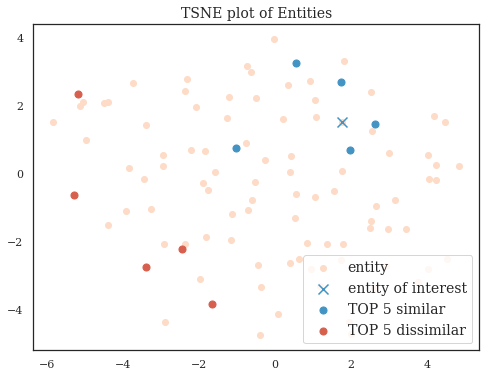

In [540]:
f = plt.figure(figsize=(8,6))
p0 = plt.scatter(entity_embed[:,0], entity_embed[:,1], color=sns.color_palette()[1])
p1 = plt.scatter(entity_embed[0:1,0], entity_embed[0:1,1], color=sns.color_palette()[-1], marker='x', s=100)

for b in best[0]:
    p2 = plt.scatter(entity_embed[b:b+1,0], entity_embed[b:b+1,1], color=sns.color_palette()[-1], s=50)

for w in worst[0]:
    p3 = plt.scatter(entity_embed[w:w+1,0], entity_embed[w:w+1,1], color=sns.color_palette()[0], s=50)

plt.legend(handles=[p0,p1,p2,p3], 
           labels=['entity', 'entity of interest', 'TOP 5 similar', 'TOP 5 dissimilar'],
          loc='lower right', ncol=1, fontsize=14)
plt.title('TSNE plot of Entities', fontsize=14)
plt.show()
f.savefig('tsne_entity.png', bbox_inches='tight')

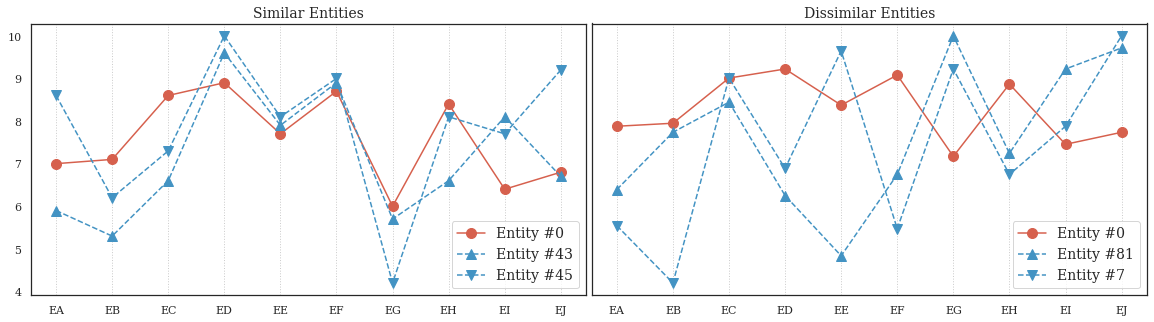

In [558]:
f = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(entity_df.loc[0], 'o-', color=sns.color_palette()[0], markersize=10)
plt.plot(entity_df.loc[43], '^--', color=sns.color_palette()[-1], markersize=10)
plt.plot(entity_df.loc[45], 'v--', color=sns.color_palette()[-1], markersize=10)
plt.title('Similar Entities', fontsize=14)
plt.grid(True, ls='dotted', axis='x')
plt.legend(['Entity #0', 'Entity #43', 'Entity #45'], fontsize=14)

plt.subplot(122)
plt.plot(entity_df.loc[0], 'o-', color=sns.color_palette()[0], markersize=10)
plt.plot(entity_df.loc[81], '^--', color=sns.color_palette()[-1], markersize=10)
plt.plot(entity_df.loc[7], 'v--', color=sns.color_palette()[-1], markersize=10)
plt.yticks([])
plt.title('Dissimilar Entities', fontsize=14)
plt.grid(True, ls='dotted')
plt.legend(['Entity #0', 'Entity #81', 'Entity #7'], fontsize=14)

plt.subplots_adjust(wspace=0.01, hspace=0.05)

f.savefig('entity_comparison.png', bbox_inches='tight')

#### USER DATAFRAME ANALYSIS

In [562]:
dis, best = recommendation(user_df, 0, user_df.columns, 'minkowski', option='best', top=5)
dis, worst = recommendation(user_df, 0, user_df.columns, 'minkowski', option='worst', top=5)

     UA    UB    UC   UD    UE   UF   UG   UH
10  6.6   7.6   6.9  9.3   8.0  5.2  5.4  4.0
25  5.5   5.6   9.6  8.1   8.1  9.2  4.7  5.3
5   4.8   8.6   6.2  8.3   7.4  6.6  7.5  2.7
15  6.3  10.0  10.0  6.1   8.6  6.9  7.2  4.3
26  5.6   7.1   5.4  5.7  10.0  9.4  2.7  7.6
     UA   UB   UC   UD   UE    UF   UG    UH
47  8.6  6.1  4.2  5.6  6.4  10.0  6.7   7.4
21  9.5  8.1  5.9  5.4  7.1   6.6  9.1   8.7
31  6.1  8.0  8.3  6.2  1.7   4.1  1.6  10.0
6   8.4  4.8  4.0  7.5  5.1   8.8  7.1   8.3
39  7.7  6.4  4.6  3.6  4.3   9.2  2.7   9.1


In [576]:
user_embed = TSNE(n_components=2).fit_transform(user_df)
user_embed.shape

(50, 2)

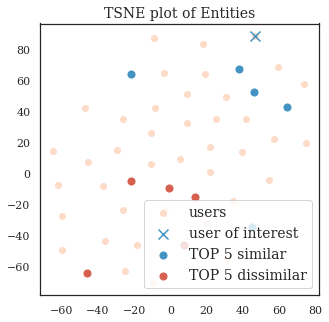

In [577]:
f = plt.figure(figsize=(5,5))
p0 = plt.scatter(user_embed[:,0], user_embed[:,1], color=sns.color_palette()[1])
p1 = plt.scatter(user_embed[0:1,0], user_embed[0:1,1], color=sns.color_palette()[-1], marker='x', s=100)

for b in best[0]:
    p2 = plt.scatter(user_embed[b:b+1,0], user_embed[b:b+1,1], color=sns.color_palette()[-1], s=50)

for w in worst[0]:
    p3 = plt.scatter(user_embed[w:w+1,0], user_embed[w:w+1,1], color=sns.color_palette()[0], s=50)

plt.legend(handles=[p0,p1,p2,p3], 
           labels=['users', 'user of interest', 'TOP 5 similar', 'TOP 5 dissimilar'],
          loc='lower right', ncol=1, fontsize=14)
plt.title('TSNE plot of Entities', fontsize=14)
plt.show()
# f.savefig('tsne_user.png', bbox_inches='tight')

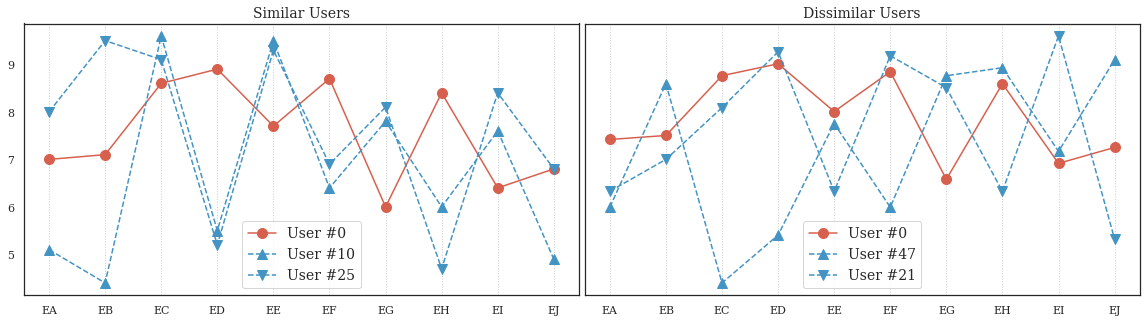

In [579]:
f = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(entity_df.loc[0], 'o-', color=sns.color_palette()[0], markersize=10)
plt.plot(entity_df.loc[best[0][0]], '^--', color=sns.color_palette()[-1], markersize=10)
plt.plot(entity_df.loc[best[0][1]], 'v--', color=sns.color_palette()[-1], markersize=10)
plt.title('Similar Users', fontsize=14)
plt.grid(True, ls='dotted', axis='x')
plt.legend(['User #0', 'User #{}'.format(best[0][0]), 'User #{}'.format(best[0][1])], fontsize=14)

plt.subplot(122)
plt.plot(entity_df.loc[0], 'o-', color=sns.color_palette()[0], markersize=10)
plt.plot(entity_df.loc[worst[0][0]], '^--', color=sns.color_palette()[-1], markersize=10)
plt.plot(entity_df.loc[worst[0][1]], 'v--', color=sns.color_palette()[-1], markersize=10)
plt.yticks([])
plt.title('Dissimilar Users', fontsize=14)
plt.grid(True, ls='dotted')
plt.legend(['User #0', 'User #{}'.format(worst[0][0]), 'User #{}'.format(worst[0][1])], fontsize=14)

plt.subplots_adjust(wspace=0.01, hspace=0.05)

# f.savefig('user_comparison.png', bbox_inches='tight')

#### Problem: Case 1 - User has history, no similar user
---

- We have a database of 100 users and 50 entities. Both users and entities have 10 attributes
- Consider user 0 with a preference table showing preferences for entities. Assuming the user has no similar user, we recommend entity based on the user's own preference.
- In this case, we identify, the entity highest ranked by the user, and recommend similar entities.


In [584]:
highest_ranked_entity_by_user = np.argmax(user_pref_df.loc[0])

In [592]:
dis, best = recommendation(entity_df, highest_ranked_entity_by_user, 
                           entity_df.columns, 'minkowski', option='best', top=5)

     EA   EB   EC   ED   EE   EF   EG   EH   EI   EJ
27  6.5  6.0  7.4  8.3  7.4  6.3  7.6  6.4  6.0  5.3
75  6.1  6.0  5.4  8.5  9.5  4.0  7.3  7.7  6.1  3.6
29  7.8  0.6  5.9  5.9  7.8  8.4  7.0  7.2  5.1  5.6
54  6.6  7.3  6.1  6.7  5.3  7.5  6.9  7.1  8.3  5.4
92  4.2  4.4  5.3  8.8  8.4  5.9  6.0  7.7  4.7  6.8


#### Result: Case 1 - User has history, no similar user
---

For **User 0**\
who has given higest rating for **entity 17**, \
the best 3 recommendations are: **Entity 27, 75, 29**

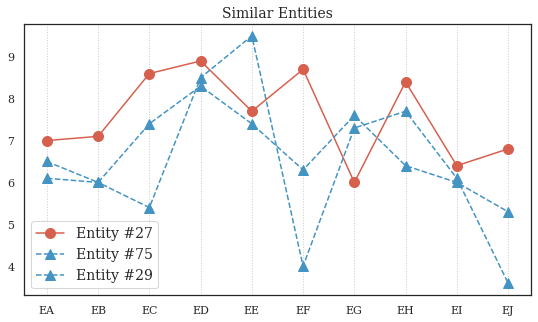

In [600]:
f = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(entity_df.loc[0], 'o-', color=sns.color_palette()[0], markersize=10)

for b in best[0][:2]:
    plt.plot(entity_df.loc[b], '^--', color=sns.color_palette()[-1], markersize=10)
plt.title('Similar Entities', fontsize=14)
plt.grid(True, ls='dotted', axis='x')
plt.legend(['Entity #{}'.format(i) for i in best[0]], fontsize=14)



# f.savefig('entity_comparison.png', bbox_inches='tight')

#### Problem: Case 2 - User has history, has similar user
---

- We have a database of 100 users and 50 entities. Both users and entities have 10 attributes
- Consider user 0 with a preference table showing preferences for entities.
- In this case, we identify, the entity highest ranked by the user, and similar users and recommend entities with best match.


In [601]:
highest_ranked_entity_by_user = np.argmax(user_pref_df.loc[0])

In [606]:
dis, best = recommendation(entity_df, highest_ranked_entity_by_user, 
                           entity_df.columns, 'minkowski', option='best', top=5)
print('\nMost Similar entities: ', best[0])

     EA   EB   EC   ED   EE   EF   EG   EH   EI   EJ
27  6.5  6.0  7.4  8.3  7.4  6.3  7.6  6.4  6.0  5.3
75  6.1  6.0  5.4  8.5  9.5  4.0  7.3  7.7  6.1  3.6
29  7.8  0.6  5.9  5.9  7.8  8.4  7.0  7.2  5.1  5.6
54  6.6  7.3  6.1  6.7  5.3  7.5  6.9  7.1  8.3  5.4
92  4.2  4.4  5.3  8.8  8.4  5.9  6.0  7.7  4.7  6.8

Most Similar entities:  [27 75 29 54 92]


In [607]:
udis, ubest = recommendation(user_df, 0, 
                             user_df.columns, 'minkowski', option='best', top=5)
print('\nMost Similar users: ', ubest[0])

     UA    UB    UC   UD    UE   UF   UG   UH
10  6.6   7.6   6.9  9.3   8.0  5.2  5.4  4.0
25  5.5   5.6   9.6  8.1   8.1  9.2  4.7  5.3
5   4.8   8.6   6.2  8.3   7.4  6.6  7.5  2.7
15  6.3  10.0  10.0  6.1   8.6  6.9  7.2  4.3
26  5.6   7.1   5.4  5.7  10.0  9.4  2.7  7.6

Most Similar users:  [10 25  5 15 26]


In [636]:
top_ranked = []
for user in ubest[0]:
    top_ranked.append(np.argsort(user_pref_df.loc[user].values)[-1])
print(user, ': ', top_ranked)

26 :  [99, 7, 54, 0, 67]


#### Result: Case 2 - User has history, has similar user
---

For **User 0**\
who has given higest rating for **entity 17**, \
the best 5 recommendations based on entity similarity: **Entity 27, 75, 29, 54, 92**\
the best 5 recommendations based on user similarity: **Entity 99, 7, 54, 0, 67**

>In real life cases, it is expected that the above have more overlaps, in which case the overlapping ones could be placed at the top

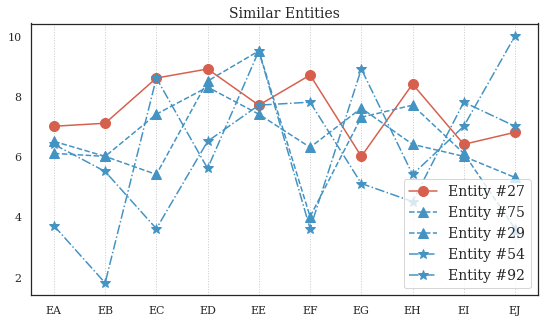

In [641]:
f = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(entity_df.loc[0], 'o-', color=sns.color_palette()[0], markersize=10)

for b in best[0][:2]:
    plt.plot(entity_df.loc[b], '^--', color=sns.color_palette()[-1], markersize=10)
for t in top_ranked[:2]:
    plt.plot(entity_df.loc[t], '*-.', color=sns.color_palette()[-1], markersize=10)
    
plt.title('Similar Entities', fontsize=14)
plt.grid(True, ls='dotted', axis='x')
plt.legend(['Entity #{}'.format(i) for i in best[0]], fontsize=14)



# f.savefig('entity_comparison.png', bbox_inches='tight')

#### Problem: Case 3 - User has no history, no similar user
---

- We have a database of 100 users and 50 entities. Both users and entities have 10 attributes
- Since there is no historic information, we need to use heuristics
- Consider heuristic: EA and EB are positive parameters of an entity and higher value is better
- We simply sort by those values and recommend top 5 entities to the user

In [655]:
highest_rated_entity = entity_df.sort_values(by=['EA','EB'], axis=0, ascending=False)

In [659]:
highest_rated_entity.index.values[0:5]

array([ 2, 42, 44, 18, 28])

#### Result: Case 3 - User has no history, no similar user
---

For **User 0** (In this case any unknown user)\
the best 5 recommendations based on entity attributes EA, EB: **Entity 2, 42, 44, 18, 28**

>In real life cases, ranking based on attribute could be such things as average review score, date of launch, energy efficiency, etc.

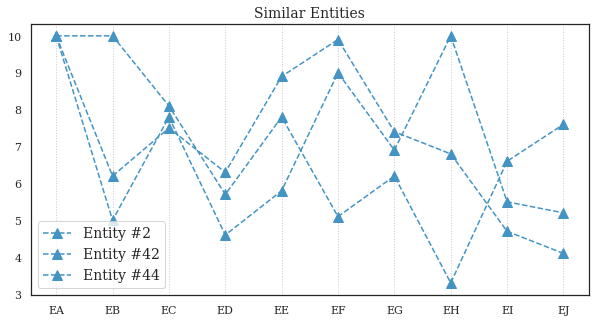

In [663]:
f = plt.figure(figsize=(10,5))
for b in highest_rated_entity.index.values[0:3]:
    plt.plot(entity_df.loc[b], '^--', color=sns.color_palette()[-1], markersize=10)
    
plt.title('Similar Entities', fontsize=14)
plt.grid(True, ls='dotted', axis='x')
plt.legend(['Entity #{}'.format(i) for i in highest_rated_entity.index.values[0:3]], fontsize=14)


# f.savefig('entity_comparison.png', bbox_inches='tight')

#### Problem: Case 4 - User has no history, has similar user
---

- We have a database of 100 users and 50 entities. Both users and entities have 10 attributes
- Since user has no historic information, we rely on history of similar users
- Consider User 0. We identify users similar to user 0 and recommend top 2 highest ranked entity for 2 most similar users

In [664]:
udis, ubest = recommendation(user_df, 0, 
                             user_df.columns, 'minkowski', option='best', top=5)
print('\nMost Similar users: ', ubest[0])

     UA    UB    UC   UD    UE   UF   UG   UH
10  6.6   7.6   6.9  9.3   8.0  5.2  5.4  4.0
25  5.5   5.6   9.6  8.1   8.1  9.2  4.7  5.3
5   4.8   8.6   6.2  8.3   7.4  6.6  7.5  2.7
15  6.3  10.0  10.0  6.1   8.6  6.9  7.2  4.3
26  5.6   7.1   5.4  5.7  10.0  9.4  2.7  7.6

Most Similar users:  [10 25  5 15 26]


In [674]:
top_ranked = []
for user in ubest[0][:2]:
    top_ranked.append(np.argsort(user_pref_df.loc[user].values)[-2:])
print(top_ranked)

[array([26, 99]), array([45,  7])]


In [675]:
top_ranked = list(set(np.concatenate(top_ranked)))
print(top_ranked)

[26, 99, 45, 7]


#### Result: Case 4 - User has no history, has similar user
---

For **User 0** \
Top 2 most similar users are: **User 10, 25**\
the best 4 recommendations based on similar users: **Entity 26, 99, 45, 7**


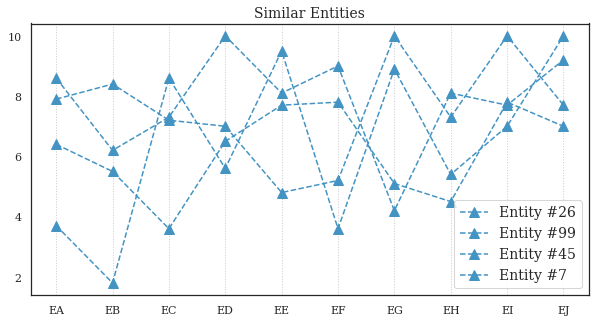

In [676]:
f = plt.figure(figsize=(10,5))
for b in top_ranked[0:4]:
    plt.plot(entity_df.loc[b], '^--', color=sns.color_palette()[-1], markersize=10)
    
plt.title('Similar Entities', fontsize=14)
plt.grid(True, ls='dotted', axis='x')
plt.legend(['Entity #{}'.format(i) for i in top_ranked[0:4]], fontsize=14)


# f.savefig('entity_comparison.png', bbox_inches='tight')

In [369]:
def get_distance(user_pref_df, threshold=0.6, pearson_threshold=1.5, method='mean'):
    """
    This function selects the distance metric based on the type of given data.
    - For dense dataset use Minkowski distance
    - For Sparse datasets use Cosine
    - For Multiple ranks/ multi rating reviews (for eg. 0-5) use Pearson
    
    Parameters:
        user_pref_df (pandas DataFrame): Data of ratings by user to entities
        threshold (float between 0,1): Ratio of number of non zeros
        pearson_threshold (float): The threshold value to select pearson distance based on variance in the data
        method: method for selecting the variance in data ('min', 'mean', 'median')
    
    Returns:
        string: Identifying the distance metric to use ('pearson', 'minkowski', 'cosine')
    """
    
    var = {}
    var['min'] = pd.Series.min(user_pref_df[user_pref_df > 0].T.var())
    var['mean'] = pd.Series.mean(user_pref_df[user_pref_df > 0].T.var())
    var['median'] = pd.Series.median(user_pref_df[user_pref_df > 0].T.var())
    
    nonzeros = np.count_nonzero(user_pref_df, axis=1).mean()/len(user_pref_df.T)
    # if the array is dense and variance is low use pearson distance
    if var[method] < pearson_threshold:
        return 'pearson'
    # if the array is dense and variance is high use minkowski distance
    if nonzeros > threshold:
        return 'minkowski'
    # if the array is sparse use cosine distance
    if nonzeros <= threshold:
        return 'cosine'
    

In [372]:
get_distance(entity_df)

'pearson'

In [390]:
pearson = np.abs(entity_df.T.corr())[0].values

In [400]:
np.argsort(np.nan_to_num(pearson,0))[-4:-1][::-1]

array([18, 57, 61])

In [434]:
sns.color_palette(sns.set_palette("RdBu",4))

[(0.8392156862745098, 0.3764705882352941, 0.30196078431372547),
 (0.9921568627450981, 0.8588235294117647, 0.7803921568627451),
 (0.8196078431372551, 0.8980392156862746, 0.9411764705882353),
 (0.2627450980392157, 0.5764705882352941, 0.7647058823529411)]

In [448]:
get_euc(entity_df.loc[0].values, entity_df.loc[65].values)

7.561745830163825

In [463]:
dis

array([[0.        , 1.08977334, 1.05621563, 1.04712136, 1.12756725,
        0.95513908, 0.51954668, 1.2353566 , 1.17730899, 0.91911708,
        0.82786523, 1.45172511, 0.88999336, 1.27910792, 0.67170172,
        0.82298688, 0.80107421, 0.75734561, 0.88676269, 0.82647876,
        0.86264327, 0.76224637, 0.69272525, 0.96133425, 1.1164793 ,
        0.87156332, 0.96717954, 0.51895942, 1.00586577, 0.90730538,
        0.626919  , 0.96057088, 0.81024477, 1.05283852, 0.86678238,
        0.7849111 , 0.75702311, 0.63987651, 0.82903058, 0.86870046,
        0.97615564, 0.74241673, 0.75751779, 0.50283247, 0.82316594,
        0.50831963, 0.83398192, 1.05196207, 1.04761208, 0.94360637,
        0.72435697, 0.80251548, 0.92147383, 1.21286156, 0.65332851,
        0.90716969, 0.89612953, 0.79510234, 0.83000362, 0.63149368,
        0.63751277, 0.86623283, 0.96184483, 1.02993481, 0.92106017,
        0.9804272 , 0.87654944, 0.57276861, 1.05517212, 0.83036059,
        0.62807016, 0.84209782, 0.72280017, 0.78

In [445]:
def get_euc(x,y):
    return np.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

In [29]:
np.count_nonzero(user_pref_df, axis=1).mean()

41.74

In [30]:
np.linalg.matrix_rank(user_df)

8

# Similar (User) Recommendation

Input: User (Row number) get best 3

In [31]:
sorted_df = np.argsort(euc)
list(sorted_df[:,1:4])

[array([385988, 315783, 423249], dtype=int64)]

In [32]:
best_3 = sorted_df[:,1:4]
best_3

array([[385988, 315783, 423249]], dtype=int64)

In [33]:
i = 0
for row in sorted_df:
    item = best_3[i]
    print(df.loc[item])
    i+=1

                                            Hotel_Address  \
385988  Nieuwezijds Voorburgwal 176 180 Amsterdam City...   
315783  Eerste Constantijn Huygensstraat 10A Oud West ...   
423249  Provincialeweg 38 Zuidoost 1108 AB Amsterdam N...   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
385988                           191   1/18/2016            8.0   
315783                           218    2/2/2016            7.5   
423249                           245  12/28/2015            7.5   

                              Hotel_Name Reviewer_Nationality  \
385988          Hotel Die Port van Cleve           Australia    
315783              Grand Hotel Downtown             Germany    
423249  Golden Tulip Amsterdam Riverside             Ireland    

                                          Negative_Review  \
385988   Firstly the check in process was a hassle imp...   
315783   My husband and I stayed in the penthouse The ...   
423249   We arrived and our toilet has fec

In [591]:
def recommendation(df, entity, columns, distance, option='best', top=3):
    #Normalize Dataframe and clean
    clean_df = df[columns].copy()
    
    clean_df = clean_df.fillna(0)
    min_max_scaler = preprocessing.MinMaxScaler()
    df_scaled = min_max_scaler.fit_transform(clean_df)
    df_scaled = pd.DataFrame(df_scaled)
    
    if 'int' in str(type(entity)):
        dis = cdist(df_scaled.loc[entity].values.reshape(1,-1), df_scaled, distance)    
    else:
        print(type(entity))
    
    sorted_df = np.argsort(dis)
    
    i = 0
    if option=='best':
        best_3 = sorted_df[:,1:top+1]
    elif option=='worst':
        best_3 = sorted_df[:,-top-1:-1]
    for row in sorted_df:
        item = best_3[i]
        print(df.loc[item])
        i+=1
        
    return dis, best_3

In [460]:
def recommendation(df, entity, columns, distance):
    #Normalize Dataframe and clean
    clean_df = df[columns].copy()
    
    clean_df = clean_df.fillna(0)
    min_max_scaler = preprocessing.MinMaxScaler()
    df_scaled = min_max_scaler.fit_transform(clean_df)
    df_scaled = pd.DataFrame(df_scaled)
    
    if type(entity) == int:
        dis = cdist(df_scaled.loc[entity].values.reshape(1,-1), df_scaled, distance)    
    else:
        print(type(entity))
    
    sorted_df = np.argsort(dis)
    
    i = 0
    best_3 = sorted_df[:,1:4]
    for row in sorted_df:
        item = best_3[i]
        #print(df.loc[item])
        i+=1
        
    return df.loc[best_3[0], 'Hotel_Name']

In [36]:
user_df

,UA,UB,UC,UD,UE,UF,UG,UH
0,1,0,0,0,0,1,0,1
1,1,1,0,0,1,0,0,1
2,0,1,0,1,0,0,1,0
3,1,1,0,1,1,0,0,0
4,0,1,0,1,0,1,0,1
5,1,1,0,1,1,0,0,0
6,1,0,0,0,0,0,1,0
7,0,0,1,1,0,0,1,0
8,1,1,0,0,1,0,0,0
9,1,1,0,0,1,0,1,0


In [37]:
x = recommendation(df, 0, ['Average_Score','Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews','Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'lat', 'lng'], 'cityblock')

C:\Users\sivam\Anaconda3\envs\DataScience\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# History recommendation

In [ ]:
def history_recommendation:
    

In [38]:
 x

250477                           Hotel Daniel Paris
250318    MARQUIS Faubourg St Honor Relais Ch teaux
250471                           Hotel Daniel Paris
Name: Hotel_Name, dtype: object

In [39]:
df.loc[x[0], 'Hotel_Name']

KeyError: 0